# Collaborative Filtering

## Factorization Machines

extend the idea of matrix factorization by modeling not only the interaction between two features (as in user-item interactions) but also any higher-order interactions between features in a dataset


In [1]:
import numpy as np
import pandas as pd

import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.multiprocessing
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

torch.manual_seed(21)
np.random.seed(21)

ratings = pd.read_csv('/kaggle/input/ml-1m-data/ml-1m/ratings.dat', delimiter='::', engine='python', names=['userId', 'movieId', 'rating', 'timestamp'])
users = pd.read_csv('/kaggle/input/ml-1m-data/ml-1m/users.dat', delimiter='::', engine='python', names=['userId', 'gender', 'age', 'occupation', 'zip-code'])
movies = pd.read_csv('/kaggle/input/ml-1m-data/ml-1m/movies.dat', delimiter='::', engine='python', names=['movieId', 'title', 'genres'], encoding='ISO-8859-1')

In [2]:
ratings["rating"] = ratings["rating"] - 3 # make range(-2, 2) for opt process

train_ratings, test_ratings = train_test_split(
    ratings, test_size=0.15, random_state=21
)

In [3]:
user_index_by_id = {id: idx for idx, id in enumerate(users["userId"]) }
gender_index_by_name = {"M":0, "F": 1}
age_index_by_name = {1: 0, 18: 1, 25: 2, 35:3, 45: 4, 50: 5, 56:6}
occupations = [
"other",
"academic/educator",
"artist",
"clerical/admin",
"college/grad student",
"customer service",
"doctor/health care",
"executive/managerial",
"farmer",
"homemaker",
"K-12 student",
"lawyer",
"programmer",
"retired",
"sales/marketing",
"scientist",
"self-employed",
"technician/engineer",
"tradesman/craftsman",
"unemployed",
"writer",
]
occupation_index_by_name = {name: index for index, name in enumerate(occupations)}

num_users = len(users)
gender_offset = num_users
age_offset = gender_offset + len(gender_index_by_name)
occupation_offset = age_offset + len(age_index_by_name)

user_features = []
for index in range(num_users):
    gender_index = gender_index_by_name[users["gender"][index]] + gender_offset
    age_index = age_index_by_name[users["age"][index]] + age_offset
    occupation_index = users["occupation"][index] + occupation_offset
    user_features.append([index, gender_index, age_index, occupation_index])

For users: index of 6040 users, 2 genders, 7 age groups and 21 occupations. The total is 6070.

For movies: index of 3883 movies and 18 genres. The total is 3901. Start movies at 6070, genres at 6070+3883=9953

In [4]:
user_features[0]

[0, 6041, 6042, 6059]

user 0, female, age 1-18, occupation K-12 student

In [5]:
movie_index_by_id = {id: idx for idx, id in enumerate(movies["movieId"])}
movie_offset = occupation_offset + len(occupation_index_by_name)

genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]
genre_index_by_name = {name:i for i, name in enumerate(genres)}
num_movies = len(movies)

movie_features = []
for i, movie_genres in enumerate(movies["genres"]):
    movie_feature = [movie_offset + i]
    for genre in movie_genres.split("|"):
        genre_index = genre_index_by_name[genre] + num_movies + movie_offset
        movie_feature.append(genre_index)
    movie_features.append(movie_feature)

In [6]:
movie_features[0]

[6070, 9955, 9956, 9957]

movieId 0, 3 genres Animation, Children's, Comedy

We will save an array containing the indices of the elements equal to one of the feature vectors of the user and the movie. Because these arrays have different sizes, to be able to train in batches, we need to add pad at the end so that the arrays have equal sizes.

In [7]:
NUM_MOVIES = len(movies)
NUM_USERS = len(users)
total_inputs = movie_offset + NUM_MOVIES + len(genres) # max num of representation
padding_idx = total_inputs


class FactorizationMachineDataset(Dataset):
    def __init__(self, rating_df):
        self.rating_df = rating_df
        self.max_size = 5 + len(genres)  # user feature:4 + movie index:1 + genres

    def __len__(self):
        return len(self.rating_df)

    def __getitem__(self, index):
        user_index = user_index_by_id[self.rating_df["userId"].iloc[index]]
        movie_index = movie_index_by_id[self.rating_df["movieId"].iloc[index]]
        rating = self.rating_df["rating"].iloc[index]
        user_feature = user_features[user_index]
        movie_feature = movie_features[movie_index]
        padding_size = self.max_size - len(user_feature) - len(movie_feature)
        feature = user_feature + movie_feature + [padding_idx] * padding_size
        return torch.IntTensor(feature), rating


training_data = FactorizationMachineDataset(train_ratings)
test_data = FactorizationMachineDataset(test_ratings)

batch_size = 1024
num_workers = 2

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, persistent_workers=True)

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [8]:
from pytorch_lightning.loggers import TensorBoardLogger

LR = 5e-4
WEIGHT_DECAY = 5e-5


class FactorizationMachine(pl.LightningModule):
    def __init__(self, num_inputs, num_factors):
        super(FactorizationMachine, self).__init__()
        self.embedding = nn.Embedding(num_inputs + 1, num_factors, padding_idx=padding_idx)
        self.embedding.weight.data.uniform_(-.1, .1)
        torch.nn.init.xavier_normal_(self.embedding.weight.data, gain=1e-3)
        self.linear_layer = nn.Embedding(num_inputs+1, 1, padding_idx=padding_idx)
        self.bias = nn.Parameter(data=torch.rand(1))
    

    def forward(self, x):
        emb = self.embedding(x)
        pow_of_sum = emb.sum(dim=1, keepdim=True).pow(2).sum(dim=2)
        sum_of_pow = emb.pow(2).sum(dim=1, keepdim=True).sum(dim=2)
        out_inter = 0.5 * (pow_of_sum - sum_of_pow)
        out_lin = self.linear_layer(x).sum(1)
        out = out_inter + out_lin + self.bias

        return torch.clip(out.squeeze(), min=-2, max=2)

    def training_step(self, batch, batch_idx):
        inputs, rating = batch
        rating = rating.to(torch.float32)
        output = self.forward(inputs)
        loss = F.mse_loss(rating, output)
        self.log("batch_loss", loss)
        return {"loss": loss}

#     def validation_step(self, batch, batch_idx):
#         inputs, rating = batch
#         rating = rating.to(torch.float32)
#         output = self.forward(inputs)
#         loss = F.mse_loss(rating, output)
#         self.log("batch_loss", loss)
#         return {"loss": loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        return optimizer

In [9]:
n_factors = 100
logger = TensorBoardLogger(
    "logs", name=f"ilr{LR}_wd{WEIGHT_DECAY}_emb{n_factors}_b{batch_size}"
)

model = FactorizationMachine(num_inputs=total_inputs, num_factors=n_factors)
trainer = pl.Trainer(accelerator='gpu', max_epochs=50, logger=logger)

trainer.fit(model, train_dataloader, test_dataloader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
def eval_model(model, train_dataloader):
    loss = 0
    for feature, rating in train_dataloader:
        pred = model(feature)
        loss += F.mse_loss(pred, rating)
    RMSE = (loss / len(train_dataloader))**.5
    return RMSE

print("Train RMSE: {:.3f}".format(eval_model(model, train_dataloader)))
print("Validation RMSE: {:.3f}".format(eval_model(model, test_dataloader)))

Train RMSE: 0.760
Validation RMSE: 0.864


In [11]:
embs_arr = model.state_dict()['embedding.weight'].detach().numpy()
movie_genres = movies["genres"]
movie_inds_one_genre = [i for i, gs in enumerate(movie_genres) if gs in ('Drama', 'Comedy', 'Horror')]

movie_embs = embs_arr[movie_offset: movie_offset + num_movies, :]
movie_subset_embs = movie_embs[movie_inds_one_genre, :]

Embedding of these movies is seen in two-dimensional space using t-SNE PCA:

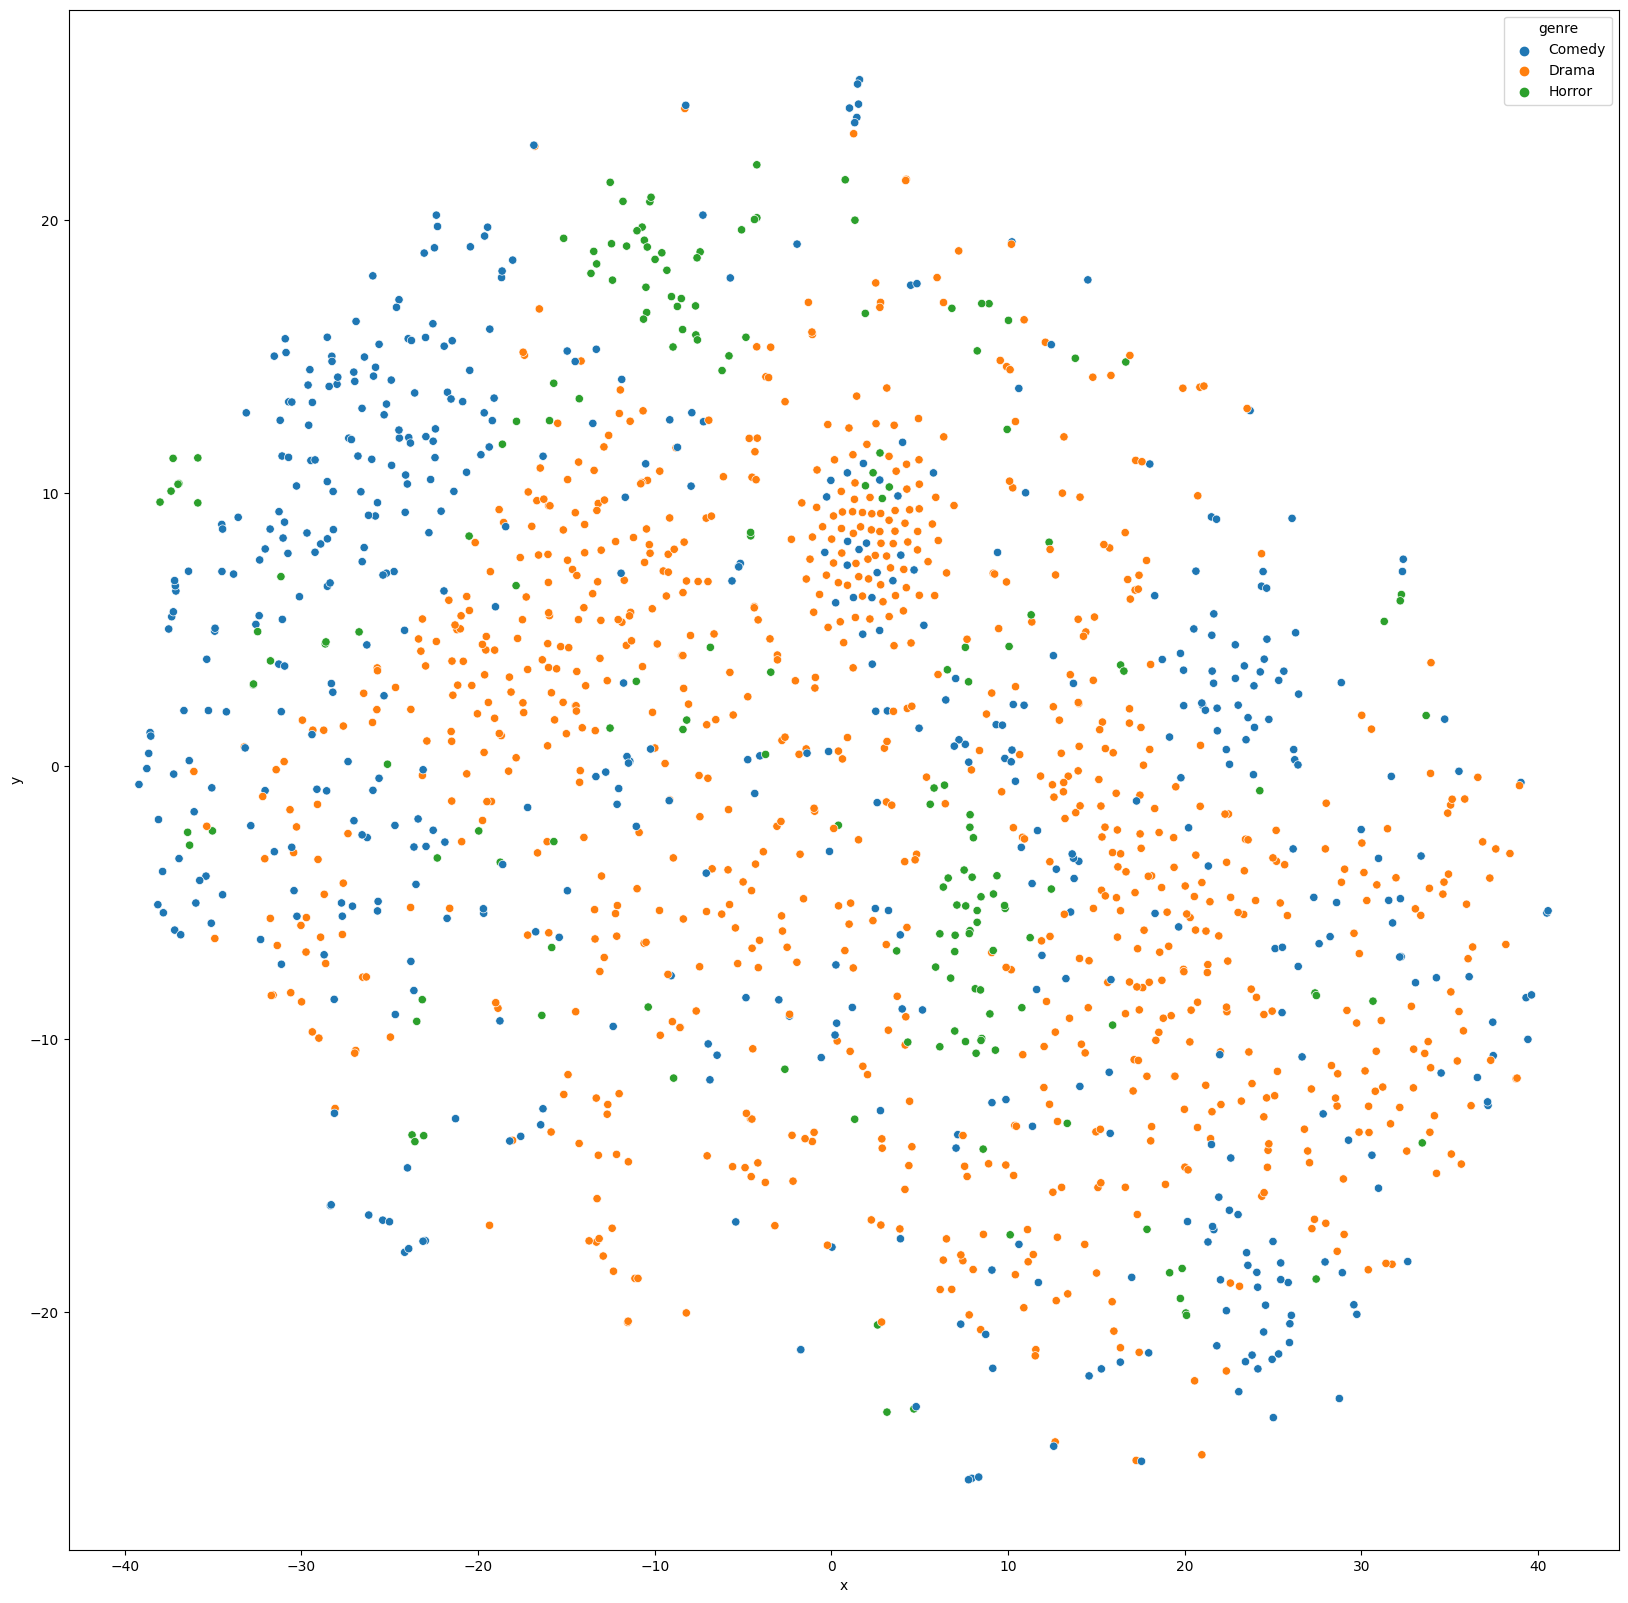

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

movie_subset_embs.shape
movie_2d = TSNE(n_components=2, init='pca').fit_transform(movie_subset_embs)
movie_df = pd.DataFrame(
    data={
        "x": movie_2d[:, 0],
        "y": movie_2d[:, 1],
        "genre": movie_genres[movie_inds_one_genre],
    }
)

plt.figure(figsize=(20, 20))
ax = sns.scatterplot(x="x", y="y", hue='genre',data=movie_df)

We can see that movies of the same genre (same color) tend to focus on areas close to each other. This proves that FM has learned useful information from the data